<a href="https://colab.research.google.com/github/MigguuelT/Miguel-Torikachvili/blob/main/Agentes_Analise_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# @title Instalações e Importações Iniciais
!pip install -q google-genai pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google import genai
from google.colab import userdata
import os
import io

In [11]:
# @title Configurações de Chave API do Gemini e de Plotagem

# Configurar o Gemini API Key
# É altamente recomendado usar o secrets do Colab para armazenar sua API key
# Vá em "Secrets" (ícone de chave) na barra lateral esquerda do Colab, adicione um novo secret
# com o nome 'GEMINI_API_KEY' e seu valor.
try:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
    model = 'gemini-2.0-flash'
    print("Gemini API configurada com sucesso!")
except Exception as e:
    print(f"Erro ao configurar Gemini API: {e}")
    print("Por favor, adicione sua GEMINI_API_KEY aos segredos do Colab ou defina-a.")
    print("Funcionalidades do Gemini podem não estar disponíveis.")

# Configurações de plotagem para melhor visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Gemini API configurada com sucesso!


In [12]:
# Listar modelos disponíveis
client = genai.Client()
for model in client.models.list():
  print(model.name)

models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.5-flash-preview-04-17-thinking
models/gemini-2.5-pro-preview-05-06
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-pr

In [13]:
# @title Agente de Carregamento e Pré-processamento

class DataLoaderAgent:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataframe = None

    def load_and_preprocess(self):
        print(f"Carregando e pré-processando o arquivo: {self.file_path}")
        try:
            # Tentar carregar com UTF-8, se falhar, tentar latin-1
            try:
                self.dataframe = pd.read_csv(self.file_path, encoding='utf-8')
            except UnicodeDecodeError:
                self.dataframe = pd.read_csv(self.file_path, encoding='latin-1')

            print("Dataset carregado com sucesso!")
            print("\nInformações iniciais do Dataset:")
            self.dataframe.info()

            # Tratar valores ausentes (exemplo: remover linhas com NaN)
            initial_rows = len(self.dataframe)
            self.dataframe.dropna(inplace=True)
            print(f"\n{initial_rows - len(self.dataframe)} linhas com valores ausentes foram removidas.")

            # Inferir e converter tipos de dados (Pandas faz isso razoavelmente bem com read_csv)
            # Tentar converter colunas para datetime se parecerem datas
            for col in self.dataframe.columns:
                if 'date' in col.lower() or 'time' in col.lower():
                    try:
                        self.dataframe[col] = pd.to_datetime(self.dataframe[col], errors='coerce')
                    except:
                        pass # Não é uma coluna de data válida

            print("\nPré-processamento concluído.")
            return self.dataframe

        except FileNotFoundError:
            print(f"Erro: Arquivo '{self.file_path}' não encontrado.")
            return None
        except Exception as e:
            print(f"Ocorreu um erro durante o carregamento/pré-processamento: {e}")
            return None

# --- Exemplo de uso do Agente de Carregamento ---
# Para este exemplo, vamos criar um CSV de exemplo.
# Em um cenário real, você faria upload de um arquivo ou forneceria um caminho.

sample_data = {
    'Produto': ['A', 'B', 'A', 'C', 'B', 'A', 'C', 'A'],
    'Vendas': [100, 150, 120, 80, 200, 110, 90, 130],
    'Regiao': ['Norte', 'Sul', 'Leste', 'Norte', 'Oeste', 'Sul', 'Leste', 'Norte'],
    'DataVenda': pd.to_datetime(['2023-01-01', '2023-01-05', '2023-01-10', '2023-01-12', '2023-01-15', '2023-01-20', '2023-01-22', '2023-01-25']),
    'Custo': [50, 70, 60, 40, 90, 55, 45, 65]
}
sample_df = pd.DataFrame(sample_data)
sample_csv_path = 'dados_exemplo.csv'
sample_df.to_csv(sample_csv_path, index=False)
print(f"Arquivo de exemplo '{sample_csv_path}' criado.")

data_loader = DataLoaderAgent(sample_csv_path)
df = data_loader.load_and_preprocess()

if df is not None:
    print("\nDataFrame após pré-processamento:")
    print(df.head())

Arquivo de exemplo 'dados_exemplo.csv' criado.
Carregando e pré-processando o arquivo: dados_exemplo.csv
Dataset carregado com sucesso!

Informações iniciais do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Produto    8 non-null      object
 1   Vendas     8 non-null      int64 
 2   Regiao     8 non-null      object
 3   DataVenda  8 non-null      object
 4   Custo      8 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 452.0+ bytes

0 linhas com valores ausentes foram removidas.

Pré-processamento concluído.

DataFrame após pré-processamento:
  Produto  Vendas Regiao   DataVenda  Custo
0       A     100  Norte  2023-01-01     50
1       B     150    Sul  2023-01-05     70
2       A     120  Leste  2023-01-10     60
3       C      80  Norte  2023-01-12     40
4       B     200  Oeste  2023-01-15     90


In [14]:
# @title Agente de Análise Descritiva

class DescriptiveAnalysisAgent:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.description_report = {}

    def analyze(self):
        if self.dataframe is None:
            print("DataFrame não fornecido para análise descritiva.")
            return None

        print("\nRealizando Análise Descritiva...")

        # Resumo estatístico para colunas numéricas
        self.description_report['numerical_summary'] = self.dataframe.describe().to_dict()

        # Contagem de valores únicos e frequência para colunas categóricas
        self.description_report['categorical_summary'] = {}
        for col in self.dataframe.select_dtypes(include=['object', 'category']).columns:
            self.description_report['categorical_summary'][col] = self.dataframe[col].value_counts().to_dict()

        # Informações sobre valores ausentes (após a remoção inicial, será 0 se dropna for usado)
        self.description_report['missing_values'] = self.dataframe.isnull().sum().to_dict()

        print("Análise Descritiva concluída.")
        return self.description_report

# --- Exemplo de uso do Agente de Análise Descritiva ---
if df is not None:
    desc_agent = DescriptiveAnalysisAgent(df)
    desc_report = desc_agent.analyze()
    if desc_report:
        print("\nRelatório de Análise Descritiva (Exemplo de um campo):")
        # Mostrar um pedaço do relatório para não sobrecarregar
        print(desc_report['numerical_summary']['Vendas'])


Realizando Análise Descritiva...
Análise Descritiva concluída.

Relatório de Análise Descritiva (Exemplo de um campo):
{'count': 8.0, 'mean': 122.5, 'std': 38.45219666769935, 'min': 80.0, '25%': 97.5, '50%': 115.0, '75%': 135.0, 'max': 200.0}


In [15]:
# @title Agente de Análise Diagnóstica e de Relações

class DiagnosticAnalysisAgent:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.diagnostic_report = {}

    def analyze(self):
        if self.dataframe is None:
            print("DataFrame não fornecido para análise diagnóstica.")
            return None

        print("\nRealizando Análise Diagnóstica e de Relações...")

        # Correlação entre variáveis numéricas
        numeric_df = self.dataframe.select_dtypes(include=['number'])
        if not numeric_df.empty:
            correlation_matrix = numeric_df.corr()
            self.diagnostic_report['correlation_matrix'] = correlation_matrix.to_dict()
            print("\nMatriz de Correlação calculada.")

        # Outros insights diagnósticos podem ser adicionados aqui, como detecção de outliers mais avançada
        # Ou análise de grupos para variáveis categóricas (ex: vendas por região)
        self.diagnostic_report['inter_variable_insights'] = {}
        if 'Produto' in self.dataframe.columns and 'Vendas' in self.dataframe.columns:
            avg_sales_by_product = self.dataframe.groupby('Produto')['Vendas'].mean()
            self.diagnostic_report['inter_variable_insights']['avg_sales_by_product'] = avg_sales_by_product.to_dict()
            print("Média de Vendas por Produto calculada.")

        print("Análise Diagnóstica concluída.")
        return self.diagnostic_report

# --- Exemplo de uso do Agente de Análise Diagnóstica ---
if df is not None:
    diag_agent = DiagnosticAnalysisAgent(df)
    diag_report = diag_agent.analyze()
    if diag_report and 'correlation_matrix' in diag_report:
        print("\nRelatório de Análise Diagnóstica (Exemplo de Correlação):")
        print(pd.DataFrame(diag_report['correlation_matrix']))


Realizando Análise Diagnóstica e de Relações...

Matriz de Correlação calculada.
Média de Vendas por Produto calculada.
Análise Diagnóstica concluída.

Relatório de Análise Diagnóstica (Exemplo de Correlação):
          Vendas     Custo
Vendas  1.000000  0.995354
Custo   0.995354  1.000000



Iniciando Geração de Gráficos Inteligente...


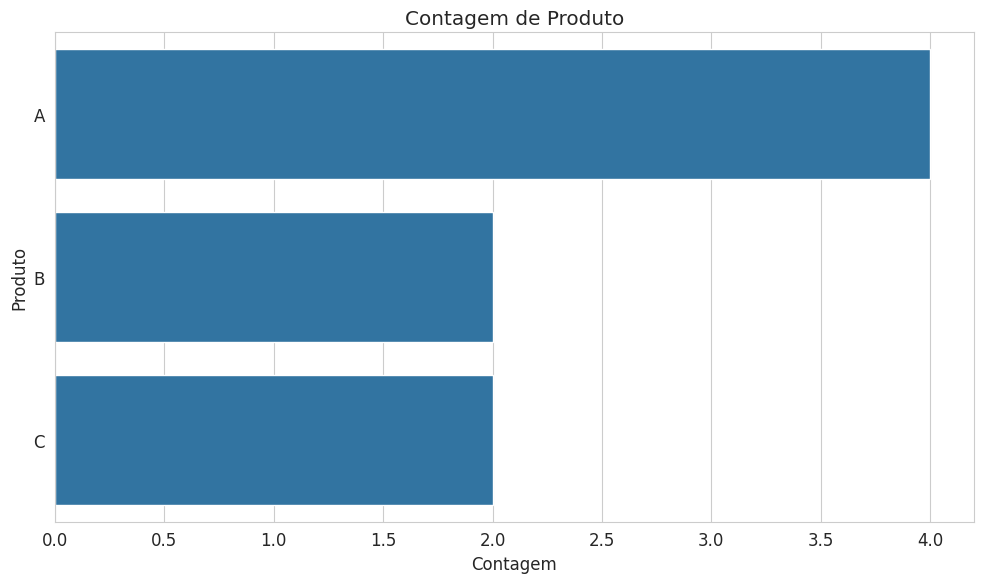

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



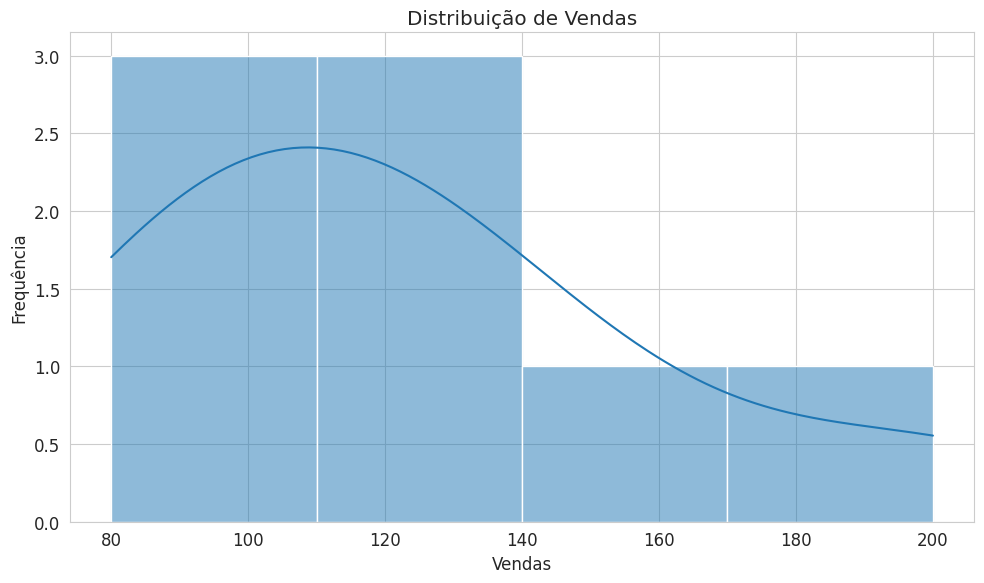

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



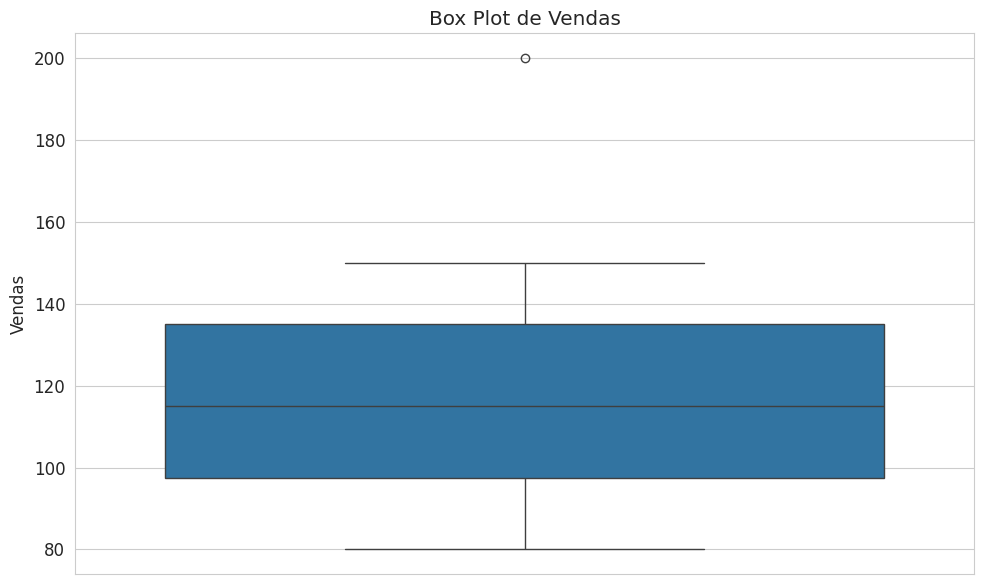

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



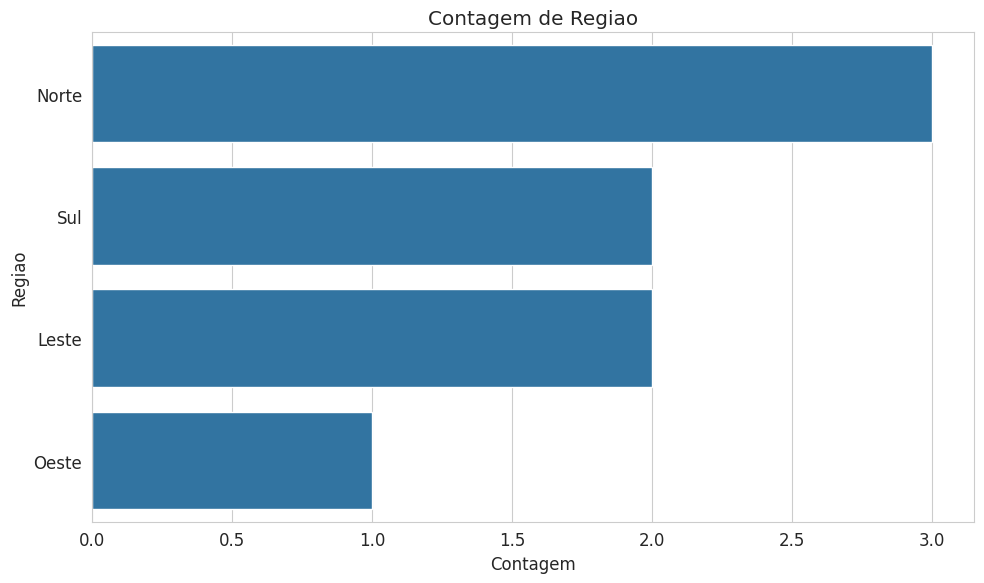

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



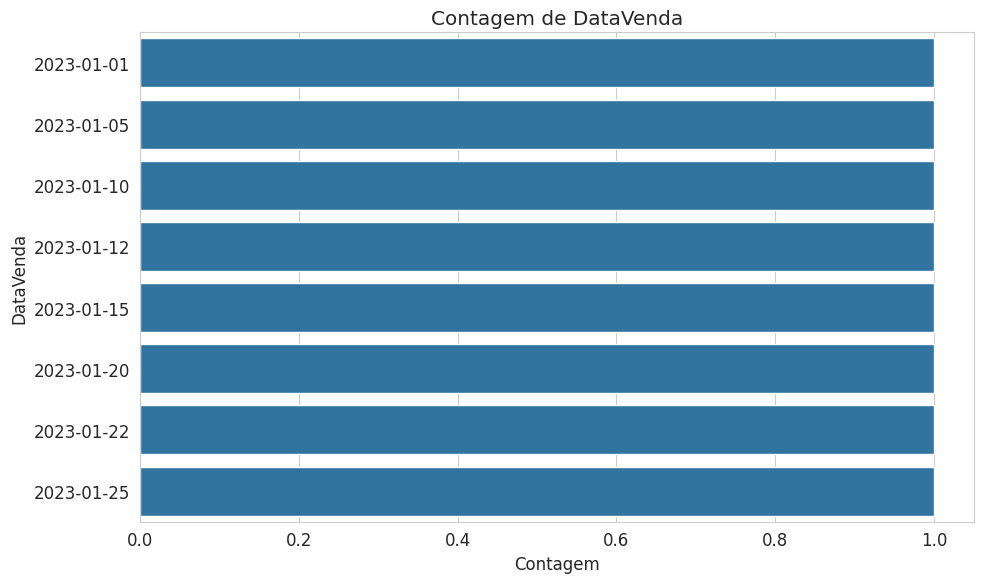

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



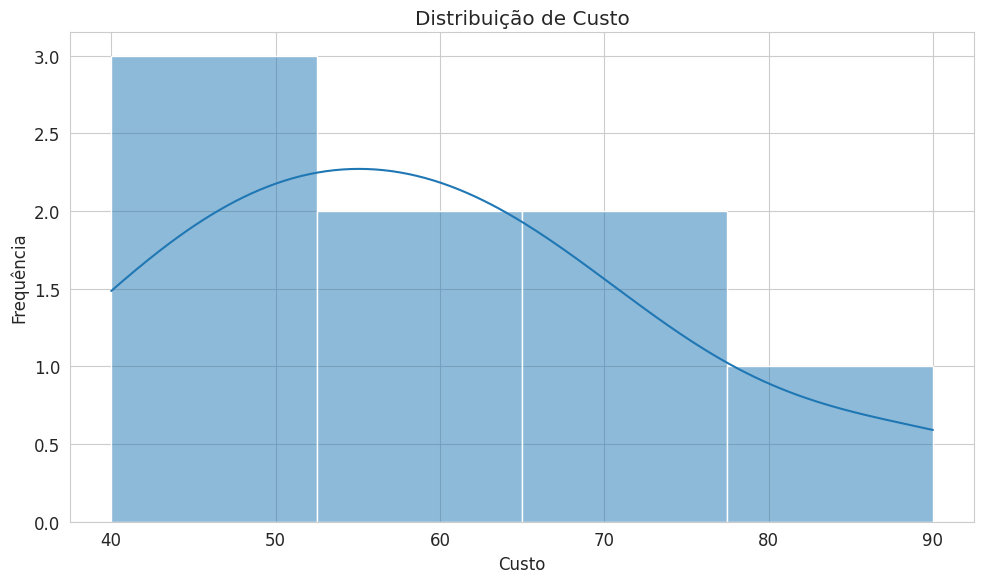

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



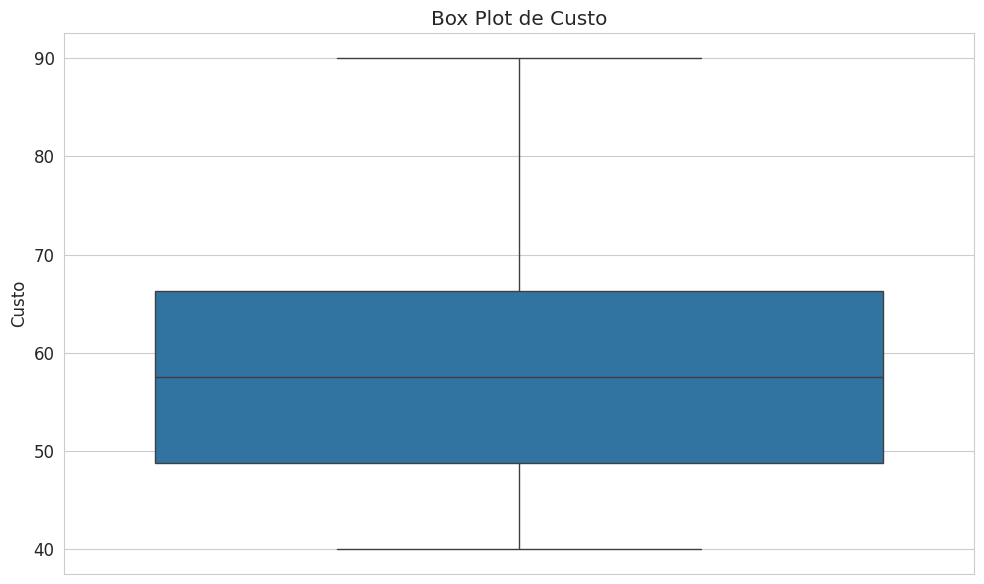

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



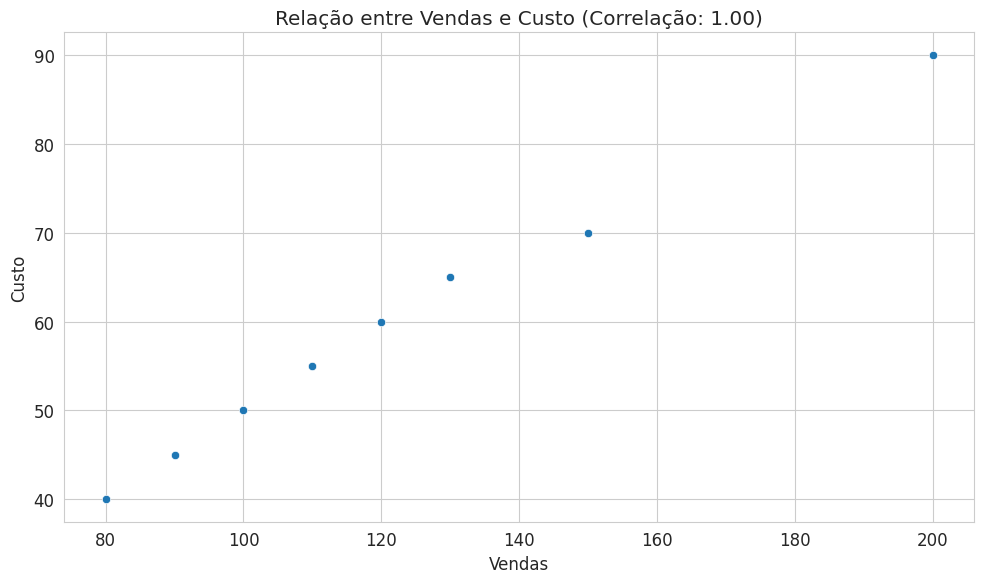

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



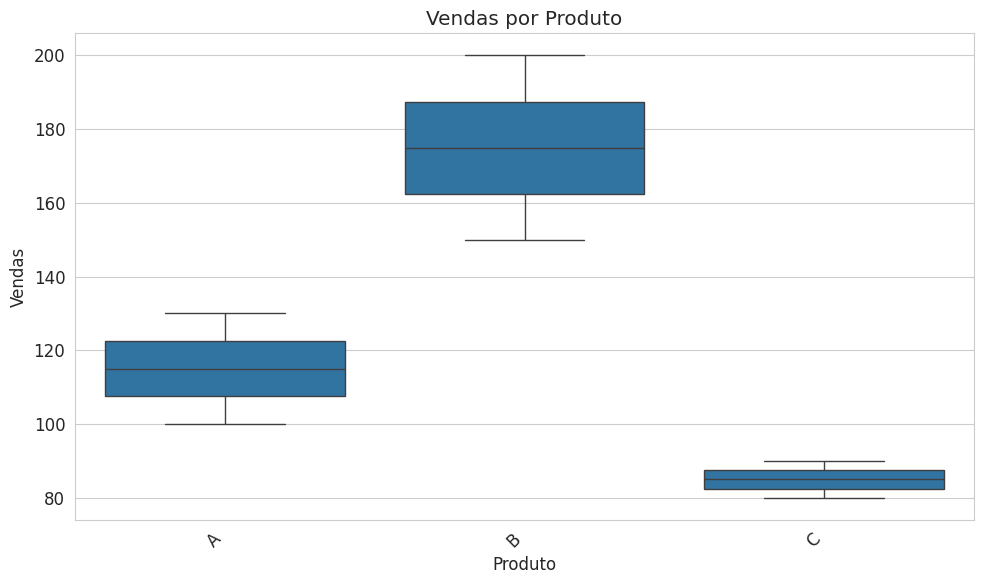

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



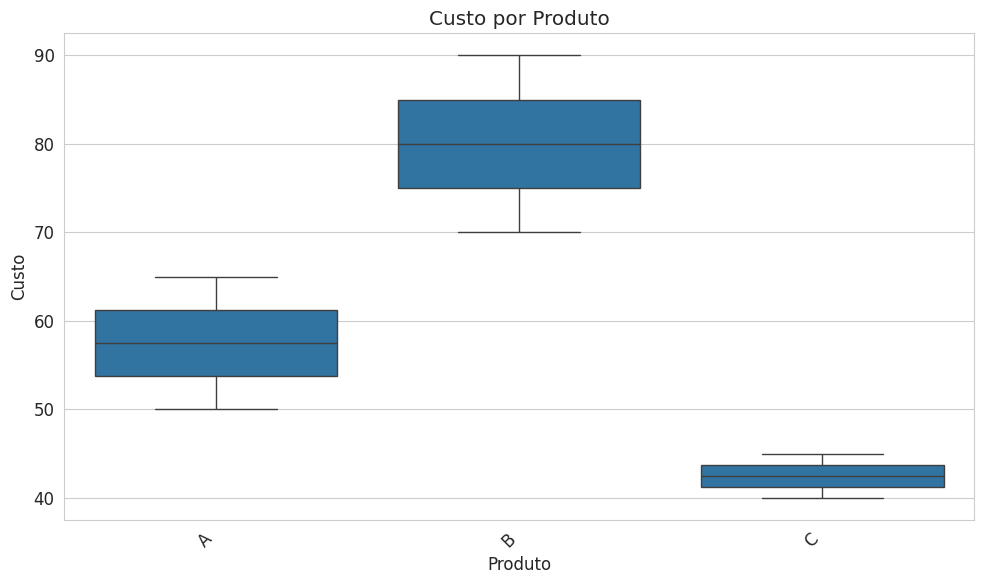

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



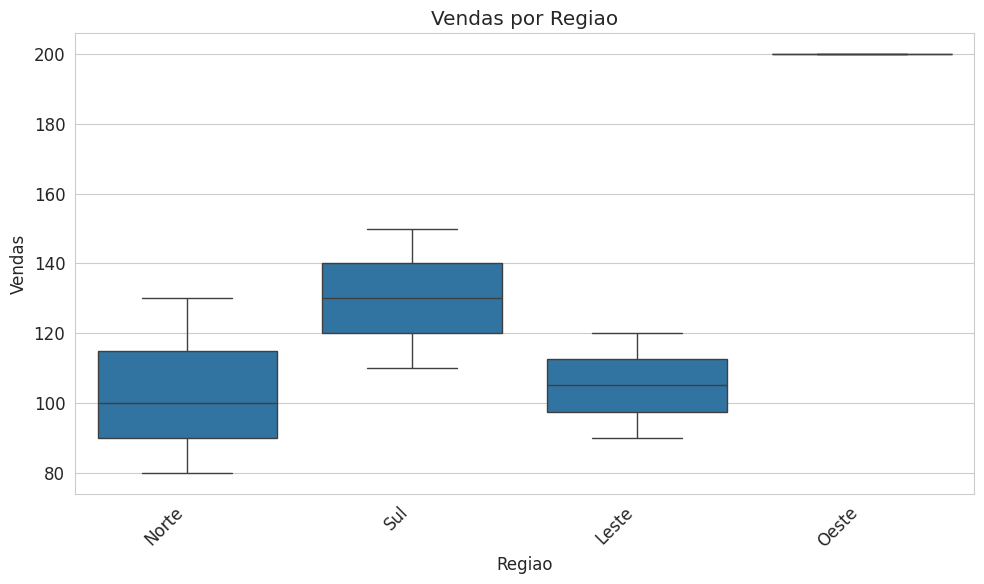

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



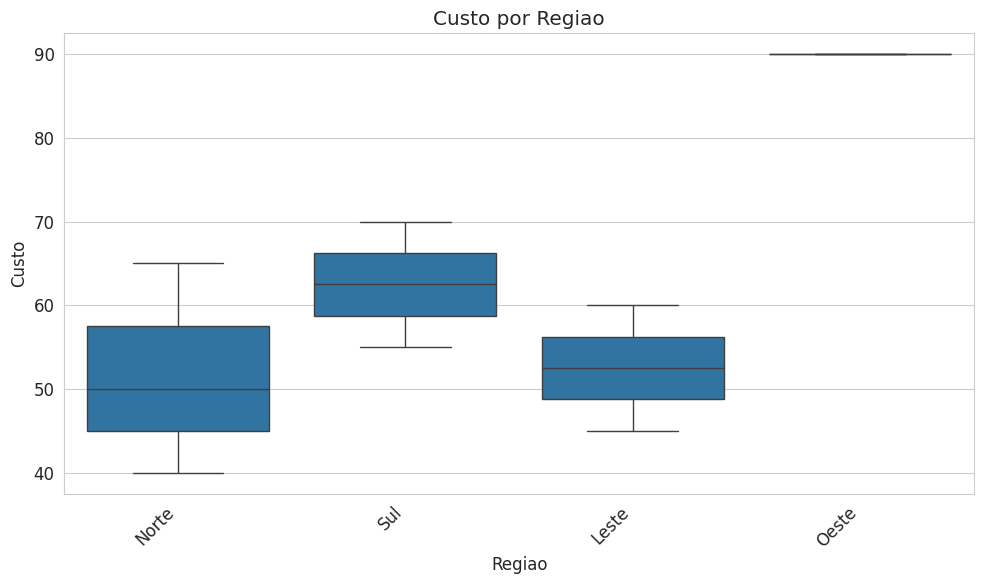

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



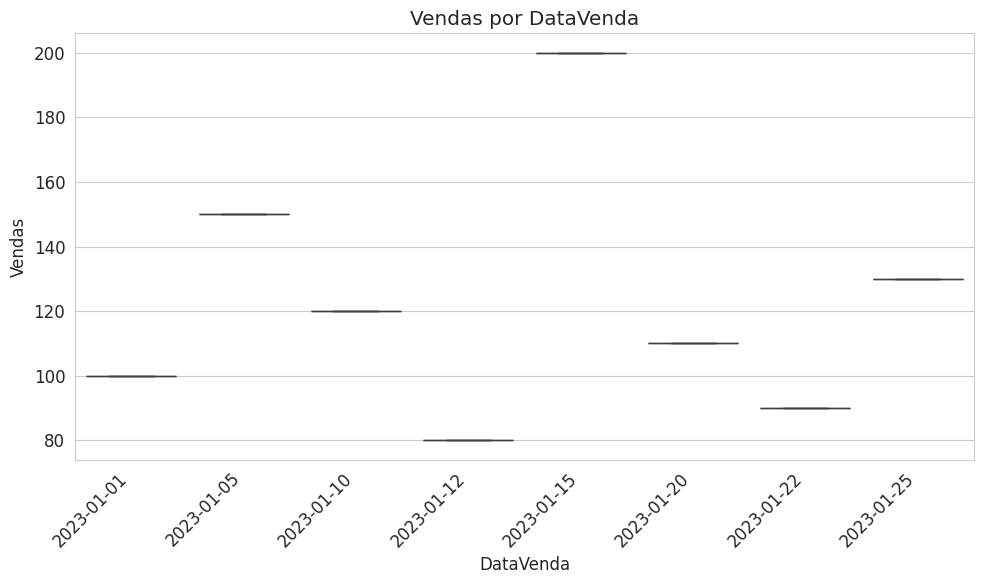

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



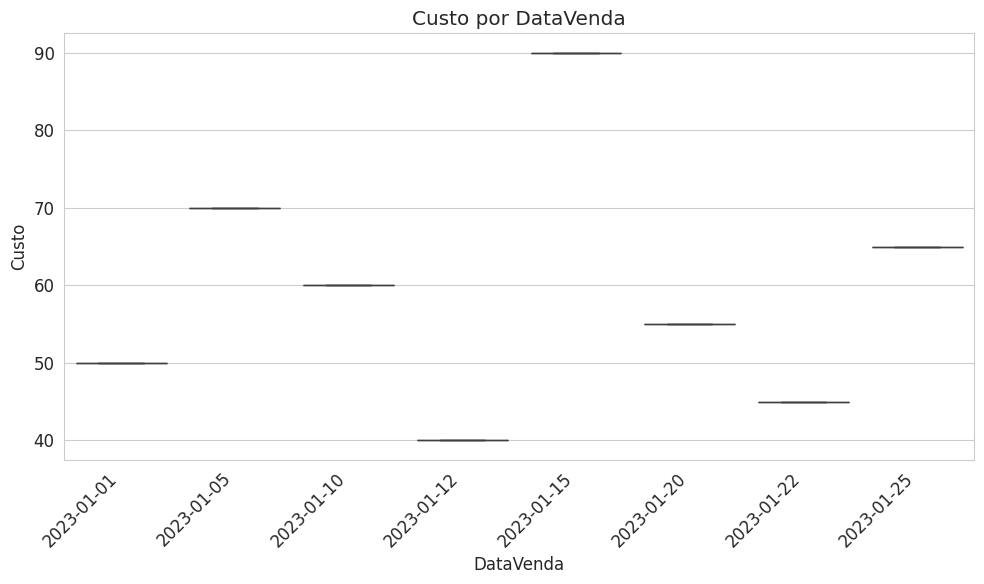

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'



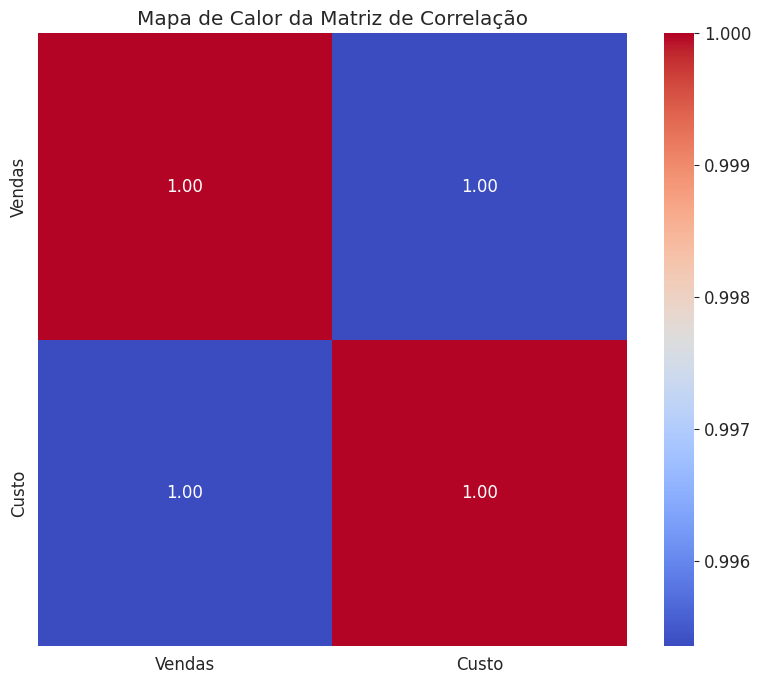

Descrição Gemini: Erro ao gerar descrição com Gemini: 'Model' object has no attribute 'generate_content'


Geração de Gráficos concluída.

Resumo dos Gráficos Gerados:
- Tipo: Gráfico de Barras, Colunas: Produto
- Tipo: Histograma, Colunas: Vendas
- Tipo: Box Plot, Colunas: Vendas
- Tipo: Gráfico de Barras, Colunas: Regiao
- Tipo: Gráfico de Barras, Colunas: DataVenda
- Tipo: Histograma, Colunas: Custo
- Tipo: Box Plot, Colunas: Custo
- Tipo: Gráfico de Dispersão, Colunas: ['Vendas', 'Custo']
- Tipo: Box Plot Agrupado, Colunas: ['Produto', 'Vendas']
- Tipo: Box Plot Agrupado, Colunas: ['Produto', 'Custo']
- Tipo: Box Plot Agrupado, Colunas: ['Regiao', 'Vendas']
- Tipo: Box Plot Agrupado, Colunas: ['Regiao', 'Custo']
- Tipo: Box Plot Agrupado, Colunas: ['DataVenda', 'Vendas']
- Tipo: Box Plot Agrupado, Colunas: ['DataVenda', 'Custo']
- Tipo: Mapa de Calor de Correlação, Colunas: ['Vendas', 'Custo']


In [16]:
# @title Agente de Escolha e Geração de Gráficos

class ChartingAgent:
    def __init__(self, dataframe, desc_report, diag_report, gemini_model=None):
        self.dataframe = dataframe
        self.desc_report = desc_report
        self.diag_report = diag_report
        self.gemini_model = gemini_model
        self.generated_charts = []

    def _generate_description_with_gemini(self, chart_type, column_info, insights=""):
        if self.gemini_model:
            prompt = f"Descreva o propósito de um {chart_type} para visualizar dados. Dada a coluna '{column_info}', e os insights: '{insights}', qual a principal conclusão que este gráfico pode indicar?"
            try:
                response = self.gemini_model.generate_content(prompt)
                return response.text
            except Exception as e:
                return f"Erro ao gerar descrição com Gemini: {e}"
        return f"Gráfico de {chart_type} para {column_info}."

    def generate_charts(self):
        if self.dataframe is None:
            print("DataFrame não fornecido para geração de gráficos.")
            return []

        print("\nIniciando Geração de Gráficos Inteligente...")

        # 1. Análise Univariada
        for col in self.dataframe.columns:
            if pd.api.types.is_numeric_dtype(self.dataframe[col]):
                # Histograma para distribuição numérica
                plt.figure()
                sns.histplot(self.dataframe[col], kde=True)
                plt.title(f'Distribuição de {col}')
                plt.xlabel(col)
                plt.ylabel('Frequência')
                plt.tight_layout()
                # plt.savefig('nome_do_arquivo.png')
                plt.show()
                desc = self._generate_description_with_gemini("Histograma", col, f"Média: {self.desc_report['numerical_summary'][col]['mean'] if col in self.desc_report['numerical_summary'] else 'N/A'}")
                print(f"Descrição Gemini: {desc}\n")
                self.generated_charts.append({'type': 'Histograma', 'column': col, 'description': desc})

                # Box Plot para outliers e quartis
                plt.figure()
                sns.boxplot(y=self.dataframe[col])
                plt.title(f'Box Plot de {col}')
                plt.ylabel(col)
                plt.tight_layout()
                # plt.savefig('nome_do_arquivo.png')
                plt.show()
                desc = self._generate_description_with_gemini("Box Plot", col, f"Mediana: {self.desc_report['numerical_summary'][col]['50%'] if col in self.desc_report['numerical_summary'] else 'N/A'}")
                print(f"Descrição Gemini: {desc}\n")
                self.generated_charts.append({'type': 'Box Plot', 'column': col, 'description': desc})

            elif pd.api.types.is_object_dtype(self.dataframe[col]) or pd.api.types.is_categorical_dtype(self.dataframe[col]):
                # Gráfico de Barras para categorias
                if self.dataframe[col].nunique() < 20: # Evitar muitos rótulos
                    plt.figure()
                    sns.countplot(y=self.dataframe[col], order=self.dataframe[col].value_counts().index)
                    plt.title(f'Contagem de {col}')
                    plt.xlabel('Contagem')
                    plt.ylabel(col)
                    plt.tight_layout()
                    # plt.savefig('nome_do_arquivo.png')
                    plt.show()
                    desc = self._generate_description_with_gemini("Gráfico de Barras", col, f"Categorias mais frequentes: {self.desc_report['categorical_summary'][col] if col in self.desc_report['categorical_summary'] else 'N/A'}")
                    print(f"Descrição Gemini: {desc}\n")
                    self.generated_charts.append({'type': 'Gráfico de Barras', 'column': col, 'description': desc})


        # 2. Análise Bivariada
        numeric_cols = self.dataframe.select_dtypes(include=['number']).columns
        object_cols = self.dataframe.select_dtypes(include=['object', 'category']).columns
        datetime_cols = self.dataframe.select_dtypes(include=['datetime64']).columns

        # Numérica vs Numérica (Scatter Plot)
        for i in range(len(numeric_cols)):
            for j in range(i + 1, len(numeric_cols)):
                col1, col2 = numeric_cols[i], numeric_cols[j]
                # Gerar scatter plot se houver correlação ou para exploração
                # Podemos usar a matriz de correlação do diag_report aqui para decidir
                correlation_val = self.diag_report.get('correlation_matrix', {}).get(col1, {}).get(col2, 0)
                if abs(correlation_val) > 0.3 or True: # Gerar para todos os pares por simplicidade
                    plt.figure()
                    sns.scatterplot(x=self.dataframe[col1], y=self.dataframe[col2])
                    plt.title(f'Relação entre {col1} e {col2} (Correlação: {correlation_val:.2f})')
                    plt.xlabel(col1)
                    plt.ylabel(col2)
                    plt.tight_layout()
                    # plt.savefig('nome_do_arquivo.png')
                    plt.show()
                    desc = self._generate_description_with_gemini("Gráfico de Dispersão", f"{col1} e {col2}", f"Correlação: {correlation_val:.2f}")
                    print(f"Descrição Gemini: {desc}\n")
                    self.generated_charts.append({'type': 'Gráfico de Dispersão', 'columns': [col1, col2], 'description': desc})

        # Categórica vs Numérica (Box Plot Agrupado)
        for cat_col in object_cols:
            if self.dataframe[cat_col].nunique() < 20: # Evitar muitos grupos
                for num_col in numeric_cols:
                    plt.figure()
                    sns.boxplot(x=self.dataframe[cat_col], y=self.dataframe[num_col])
                    plt.title(f'{num_col} por {cat_col}')
                    plt.xlabel(cat_col)
                    plt.ylabel(num_col)
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    # plt.savefig('nome_do_arquivo.png')
                    plt.show()
                    avg_sales_by_cat = self.diag_report.get('inter_variable_insights', {}).get(f'avg_sales_by_{cat_col.lower()}', {})
                    desc = self._generate_description_with_gemini("Box Plot Agrupado", f"{num_col} por {cat_col}", f"Média por categoria: {avg_sales_by_cat}")
                    print(f"Descrição Gemini: {desc}\n")
                    self.generated_charts.append({'type': 'Box Plot Agrupado', 'columns': [cat_col, num_col], 'description': desc})


        # 3. Análise Temporal (Gráfico de Linha)
        if datetime_cols.any() and numeric_cols.any():
            date_col = datetime_cols[0] # Pega a primeira coluna de data/hora encontrada
            for num_col in numeric_cols:
                # Agrupar por data para séries temporais (se houver várias entradas por dia)
                temp_df_agg = self.dataframe.groupby(date_col)[num_col].mean().reset_index()
                plt.figure()
                sns.lineplot(x=temp_df_agg[date_col], y=temp_df_agg[num_col])
                plt.title(f'Tendência de {num_col} ao longo do tempo')
                plt.xlabel('Data')
                plt.ylabel(num_col)
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                # plt.savefig('nome_do_arquivo.png')
                plt.show()
                desc = self._generate_description_with_gemini("Gráfico de Linha", f"{num_col} ao longo do tempo", f"Tendência observada.")
                print(f"Descrição Gemini: {desc}\n")
                self.generated_charts.append({'type': 'Gráfico de Linha', 'columns': [date_col, num_col], 'description': desc})

        # 4. Análise Multivariada (Heatmap de Correlação)
        if len(numeric_cols) > 1:
            correlation_matrix_df = pd.DataFrame(self.diag_report['correlation_matrix'])
            plt.figure(figsize=(8, 7))
            sns.heatmap(correlation_matrix_df, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Mapa de Calor da Matriz de Correlação')
            plt.tight_layout()
            # plt.savefig('nome_do_arquivo.png')
            plt.show()
            desc = self._generate_description_with_gemini("Mapa de Calor de Correlação", "Múltiplas variáveis numéricas", "Identifica relações fortes entre variáveis.")
            print(f"Descrição Gemini: {desc}\n")
            self.generated_charts.append({'type': 'Mapa de Calor de Correlação', 'columns': list(numeric_cols), 'description': desc})

        print("\nGeração de Gráficos concluída.")
        return self.generated_charts

# --- Exemplo de uso do Agente de Geração de Gráficos ---
if df is not None and desc_report and diag_report:
    # Passamos o 'model' do Gemini se ele foi configurado com sucesso
    chart_agent = ChartingAgent(df, desc_report, diag_report, gemini_model=model if 'model' in locals() else None)
    all_charts = chart_agent.generate_charts()

    print("\nResumo dos Gráficos Gerados:")
    for chart_info in all_charts:
        print(f"- Tipo: {chart_info['type']}, Colunas: {chart_info.get('column', chart_info.get('columns'))}")
        # A descrição gerada pelo Gemini já é impressa na hora